# Notes on developing and testing attended mode in XApRES
Notes on developing and testing loading and structuring ApRES data collected in attended mode. 


In [1]:
import sys
sys.path.append(
    "/Users/jkingslake/Documents/science/ApRES/xapres/xapres')
import ApRESDefs
import importlib
importlib.reload(ApRESDefs)

import xarray as xr
import numpy as np

## This is how to load unattended dat files found recursively in a file structure

In [56]:
xa_temp = ApRESDefs.xapres(loglevel="DEBUG")
xa_temp.load_all(directory='../../data/sample/polarmetric/',)
xa_temp.data


<xarray.Dataset>
Dimensions:          (time: 4, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-05T03:16:15 ... 2023-01-05...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U56 '../../data/sample/polarmetric/DATA2023-01-0...
    burst_number     (time) int64 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      (time) <U2 'VH' 'HV' 'HH' 'VV'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0 0.0 0.0 0.0
    longitude        (time) float64 0.0 0.0 0.0 0.0
    battery_voltage  (time) float64 0.0 0.0 0.0 0.0
    temperature_1    (time) float64 2.891 503.1 502.9 2.492
    temperature_2    (time) float64 511.8 503.6 501.6 4.93

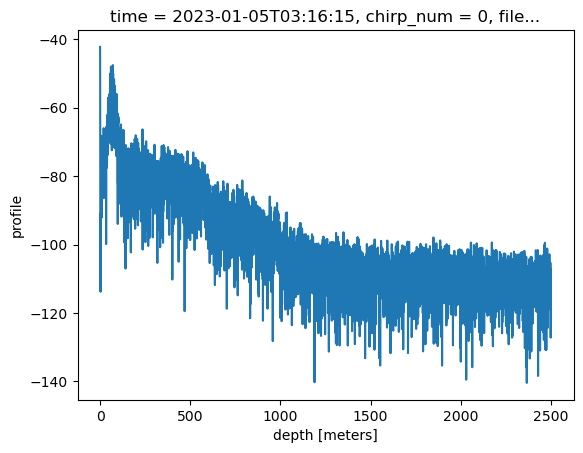

In [62]:
xa_temp.data.profile.db().isel(time=0, chirp_num=0).plot()


In [52]:
xa_temp.data.profile

<xarray.Dataset>
Dimensions:          (time: 4, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-05T03:16:15 ... 2023-01-05...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U56 '../../data/sample/polarmetric/DATA2023-01-0...
    burst_number     (time) int64 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      (time) <U2 'VH' 'HV' 'HH' 'VV'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0 0.0 0.0 0.0
    longitude        (time) float64 0.0 0.0 0.0 0.0
    battery_voltage  (time) float64 0.0 0.0 0.0 0.0
    temperature_1    (time) float64 2.891 503.1 502.9 2.492
    temperature_2    (time) float64 511.8 503.6 501.6 4.93

## This is one way to  get an xarray from one burst

In [5]:
xa = ApRESDefs.xapres()
files = xa.list_files(directory='../../data')
dat = xa.load_dat_file(files[0])
burst = dat.ExtractBurst(0)

singleBurst_xarray = xa._burst_to_xarray(burst)

## The next two cells get xarrays arranged in the old "unattended mode" way and rearrange them into "attended mode".
## They differ in the xarray that they stat with. The first one starts with an xarray made by load_all applied to one dat file. The second one uses lower level function to load an xarray corresponding to one burst. 
## In this dataset there is only one burst in each dat file, so the results should be the same in each case. 

In [4]:
# version 1 using load_all to get the initial xarray

# do the following for each waypoint, then concatenate the results over the waypoint dimension
waypoint_number = 1


# initialize an empy array to contain the individual xarras
list_of_singleOrientation_xarrays = []

# loop over the orientations
for fileNumber in [0, 1, 2, 3]:
    xa = ApRESDefs.xapres()
    xa.load_all(directory='../../data', file_numbers_to_process=[fileNumber])

    new_dims = {"orientation": 1, "waypoint": 1}
    
    # add a new coordinate waypoints, then remove the dimension time, then add two more dimensions orientation and waypoint
    temp = xa.data.assign_coords(waypoint = waypoint_number).squeeze(dim = 'time').expand_dims(dim =  new_dims)

    # the line above only adds coordinates and dimensions to the variables, these three lines add them to the coordintates too 
    temp['time'] = temp.time.expand_dims(dim =  new_dims)
    temp['filename'] = temp.filename.expand_dims(dim = new_dims)
    temp['burst_number'] = temp.burst_number.expand_dims(dim = new_dims)

    # append the new xarray to a list
    list_of_singleOrientation_xarrays.append(temp)

# concatenate the xarrays in the list along the orientation dimension
singleWaypoint_v1 = xr.concat(list_of_singleOrientation_xarrays, dim = 'orientation')

singleWaypoint_v1

<xarray.Dataset>
Dimensions:          (orientation: 4, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 2023-01-05T03:16:...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (orientation, waypoint) <U56 '../../data/sample/polarmet...
    burst_number     (orientation, waypoint) int64 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
  * orientation      (orientation) <U2 'VH' 'HV' 'HH' 'VV'
  * waypoint         (waypoint) int64 1
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    longitude        (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    temperature_1    (orientation, waypoint) float64 2.891 503.1 502.9 2.492
    temperature_2    (orientation, waypoint) float64 511.8 503.6 501.6 4.93

In [7]:
singleWaypoint_v1.nbytes/1e6

204.509896

In [12]:
singleBurst_xarray

<xarray.Dataset>
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-05T03:13:29
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U56 '../../data/sample/polarmetric/DATA2023-01-0...
    burst_number     (time) int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      (time) <U2 'VV'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0
    longitude        (time) float64 0.0
    battery_voltage  (time) float64 0.0
    temperature_1    (time) float64 2.492
    temperature_2    (time) float64 4.93

In [8]:
# version 2 using lower-level functions load_dat_file and ExtractBurst


# do the following for each waypoint, then concatenate the results over the waypoint dimension
waypoint_number = 1


# initialize an empy array to contain the individual xarras
list_of_singleOrientation_xarrays = []

# loop over the orientations
for fileNumber in [0, 1, 2, 3]:
    xa = ApRESDefs.xapres()
    files = xa.list_files(directory='../../data')
    dat = xa.load_dat_file(files[fileNumber])
    burst = dat.ExtractBurst(0)
    
    singleBurst_xarray = xa._burst_to_xarray(burst)
    
    new_dims = {"orientation": 1, "waypoint": 1}
    
    # add a new coordinate waypoints, then remove the dimension time, then add two more dimensions orientation and waypoint
    temp = singleBurst_xarray.assign_coords(waypoint = waypoint_number).squeeze(dim = 'time').expand_dims(dim =  new_dims)

    # the line above only adds coordinates and dimensions to the variables, these three lines add them to the coordintates too 
    temp['time'] = temp.time.expand_dims(dim =  new_dims)
    temp['filename'] = temp.filename.expand_dims(dim = new_dims)
    temp['burst_number'] = temp.burst_number.expand_dims(dim = new_dims)

    # append the new xarray to a list
    list_of_singleOrientation_xarrays.append(temp)

# concatenate the xarrays in the list along the orientation dimension
singleWaypoint_v2 = xr.concat(list_of_singleOrientation_xarrays, dim = 'orientation')

singleWaypoint_v2

<xarray.Dataset>
Dimensions:          (orientation: 4, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 2023-01-05T03:16:...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (orientation, waypoint) <U56 '../../data/sample/polarmet...
    burst_number     (orientation, waypoint) int64 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
  * orientation      (orientation) <U2 'VH' 'HV' 'HH' 'VV'
  * waypoint         (waypoint) int64 1
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    longitude        (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    temperature_1    (orientation, waypoint) float64 2.891 503.1 502.9 2.492
    temperature_2    (orientation, waypoint) float64 511.8 503.6 501.6 4.93

In [ ]:
singleWaypoint_v2.equals(singleWaypoint_v1)

## this ^ is good

## I think that we should just concat the waypoints in the order that we find the dat files. The alternative would be to devise an automated approach to deciding the order based on either position information stored in the burst headers, or in separate metadata, or based on the filenames. Given that Elizabeth's TG ApRES data does not have a simple file naming convention, nor does it have postion data in the burst headers, I wont put time into doing this now. 
## The user can then rearrange things in the `waypoint` dimension using whatever metadata they have.

## There is a choice to be made about how to modify ApRESDefs to account for attended data. Either we build an unattended xarray for each burst and modify it in the way shown above, or we build the attended one from the raw data. Probably the latter is better. 

# Rewriting _burst_to_xarrayto create attended mode version of the structure

This is the version of _burst_to_xarray that already exists in the code

In [16]:
xa = ApRESDefs.xapres()
files = xa.list_files(directory='../../data')
dat = xa.load_dat_file(files[0])
burst = dat.ExtractBurst(0)

#burst = dat.ExtractBurst(burst_number)
def _burst_to_xarray_unattended(burst):
    """Return an xarray containing all data from one burst with appropriate coordinates"""

    #self.logger.debug(f"Put all chirps and profiles from burst number {burst.BurstNo} in 3D arrays")
    chirps, profiles = xa._burst_to_3d_arrays(burst)
    chirp_time, profile_range = xa._coords_from_burst(burst)
    time = xa._timestamp_from_burst(burst)
    #self.logger.debug(f"Get orientation from filename")
    orientation = xa._get_orientation(burst.Filename)
    print(orientation)
    chirps = chirps[None,:,:,:]
    profiles = profiles[None,:,:,:]

    xarray_out = xr.Dataset(
        data_vars=dict(
            chirp           = (["time","chirp_time", "chirp_num", "attenuator_setting_pair"], chirps),
            profile         = (["time", "profile_range", "chirp_num", "attenuator_setting_pair"], profiles),
            latitude        = (["time"], [burst.Header['Latitude']]),
            longitude       = (["time"], [burst.Header['Longitude']]),  
            battery_voltage = (["time"], [burst.Header['BatteryVoltage']]), 
            temperature_1   = (["time"], [burst.Header['Temp1']]),
            temperature_2   = (["time"], [burst.Header['Temp2']])
        ),
        coords=dict(
            time                  = [time],
            chirp_time            = chirp_time,
            profile_range         = profile_range, 
            chirp_num             = np.arange(burst.Header['NSubBursts']),
            filename              = (["time"], [burst.Filename]),
            burst_number          = (["time"], [burst.BurstNo]),
            AFGain                = (["attenuator_setting_pair"], burst.Header['AFGain'][0:burst.Header['nAttenuators']]),
            attenuator            = (["attenuator_setting_pair"], burst.Header['Attenuator1'][0:burst.Header['nAttenuators']]),
            orientation           = (["time"], [orientation])
        ),
    )
    return xarray_out
    
singleBurst_xarray_unattended = _burst_to_xarray_unattended(burst)
singleBurst_xarray_unattended

VH


<xarray.Dataset>
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-05T03:16:15
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U56 '../../data/sample/polarmetric/DATA2023-01-0...
    burst_number     (time) int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      (time) <U2 'VH'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0
    longitude        (time) float64 0.0
    battery_voltage  (time) float64 0.0
    temperature_1    (time) float64 2.891
    temperature_2    (time) float64 511.8

#### The cell below is a new attended version of _burst_to_xarray
It is intended to load an xarray in the attended format.

It is succcesfully loading a single burst and putting it in the correct format for attended mode. 
The issue previously was that all the variables and coordinates needed to have two extra dimensions at the start to take account of the orientation and waypoint dimensions and I wasnt doing this in the proper way. 

In [27]:
#burst = dat.ExtractBurst(burst_number)
def _burst_to_xarray_attended(burst):
    """Return an xarray containing all data from one burst with appropriate coordinates"""

    #self.logger.debug(f"Put all chirps and profiles from burst number {burst.BurstNo} in 3D arrays")
    
    #xa = ApRESDefs.xapres()
    #files = xa.list_files(directory='../../data')
    #dat = xa.load_dat_file(files[0])
    #burst = dat.ExtractBurst(0)
    waypoint = 1
    chirps_temp, profiles_temp = xa._burst_to_3d_arrays(burst)
    chirp_time, profile_range = xa._coords_from_burst(burst)
    time_temp = xa._timestamp_from_burst(burst)
    #self.logger.debug(f"Get orientation from filename")
    orientation = xa._get_orientation(burst.Filename)
    
    chirps = chirps_temp[None,None,:,:,:]
    profiles = profiles_temp[None,None,:,:,:]
    #time = time_temp[None,None,:]
    #time = np.expand_dims(time_temp, axis=0)
    
    xarray_out = xr.Dataset(
        data_vars=dict(
            chirp           = (["orientation", "waypoint", "chirp_time", "chirp_num", "attenuator_setting_pair"], chirps),
            profile         = (["orientation", "waypoint", "profile_range", "chirp_num", "attenuator_setting_pair"], profiles),
            latitude        = (["orientation", "waypoint"], np.array(burst.Header['Latitude'], ndmin = 2)),
            longitude       = (["orientation", "waypoint"], np.array(burst.Header['Latitude'], ndmin = 2)),
            battery_voltage = (["orientation", "waypoint"], np.array(burst.Header['BatteryVoltage'], ndmin = 2)),
            temperature_1   = (["orientation", "waypoint"], np.array(burst.Header['Temp1'], ndmin = 2)),
            temperature_2   = (["orientation", "waypoint"], np.array(burst.Header['Temp2'], ndmin = 2))
        ),
        coords=dict(
            time                  = (["orientation", "waypoint"], np.array(time_temp, ndmin = 2)),
            chirp_time            = chirp_time,
            profile_range         = profile_range, 
            chirp_num             = np.arange(burst.Header['NSubBursts']),
            filename              = (["orientation", "waypoint"], np.array(burst.Filename, ndmin = 2)), 
            burst_number          = (["orientation", "waypoint"], np.array(burst.BurstNo, ndmin = 2)),   
            AFGain                = (["attenuator_setting_pair"], burst.Header['AFGain'][0:burst.Header['nAttenuators']]),
            attenuator            = (["attenuator_setting_pair"], burst.Header['Attenuator1'][0:burst.Header['nAttenuators']]),
            orientation           = [orientation],
            waypoint              = [waypoint]
        ),
    )
    return xarray_out

def directory_names(counter=0):
    """Generates directory names to loop over. If the survey is polarmetric, each directory should include four files, corresponding to four pairs of antenna orientations: HH, HV, VH, VV."""

    return f"../../data"
#singleBurst_xarray_attended = _burst_to_xarray_attended(burst)
#singleBurst_xarray_attended

In [36]:
directory_names = None
if not directory_names:
    print('yes')

yes


In [38]:
for item in [""]:
    print('loop')

loop


In [3]:
def _all_bursts_at_waypoint_to_xarray(directory, polarmetric=True):   # this is the attended equivalent to _all_bursts_in_dat_to_xarray
    
    # initialize an empty array to contain the individual xarras
    list_of_singleorientation_attended_xarrays = []
    
    # loop over the orientations
    for orientation in ['HH', 'HV', 'VH', 'VV']:
        
        xa = ApRESDefs.xapres()
        files = xa.list_files(directory=directory, search_suffix=orientation)
        if len(files) > 1:
            raise Exception('there should only be one dat file for each orientation in each directory')
        dat = xa.load_dat_file(files[0])
        
        burst = dat.ExtractBurst(0)
        print(burst.v)
        
        
        singleorientation_attended_xarray = _burst_to_xarray_attended(burst)
        
        print(singleorientation_attended_xarray.orientation.values)
        
        # append the new xarray to a list
        list_of_singleorientation_attended_xarrays.append(singleorientation_attended_xarray)
    
    # concatenate the xarrays in the list along the orientation dimension
    return list_of_singleorientation_attended_xarrays, xr.concat(list_of_singleorientation_attended_xarrays, dim = 'orientation')

list_of_singleorientation_attended_xarrays, waypoint_1 = _all_bursts_at_waypoint_to_xarray(directory_names(0))

Exception: there should only be one dat file for each orientation in each directory

In [79]:
waypoint_1.sel(chirp_num = 0).chirp.time


<xarray.DataArray 'time' (orientation: 4, waypoint: 1)>
array([['2023-01-05T03:07:50.000000000'],
       ['2023-01-05T03:10:34.000000000'],
       ['2023-01-05T03:16:15.000000000'],
       ['2023-01-05T03:13:29.000000000']], dtype='datetime64[ns]')
Coordinates:
    time          (orientation, waypoint) datetime64[ns] 2023-01-05T03:07:50 ...
    chirp_num     int64 0
    filename      (orientation, waypoint) <U56 '../../data/sample/polarmetric...
    burst_number  (orientation, waypoint) int64 0 0 0 0
  * orientation   (orientation) <U2 'HH' 'HV' 'VH' 'VV'
  * waypoint      (waypoint) int64 1

## Testing out the implementation of these functions in ApRESDefs.py

In [49]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres/xapres")
import ApRESDefs
import importlib
importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel="DEBUG")
xa.load_all(attended=True, directory=["../../data/sample/polarmetric", "../../data/sample/polarmetric"], polarmetric=True)

DEBUG    20:32:12 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    20:32:12 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    20:32:12 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG
DEBUG    20:32:12 	 ApRESDefs.py @function load_all line 191 - Start call to load_all with remote_load = False, directory = ['../../data/sample/polarmetric', '../../data/sample/polarmetric'], file_numbers_to_process = None, file_names_to_process = None, bursts_to_process = All, attended = True
DEBUG    20:32:12 	 ApRESDefs.py @function load_all line 227 - Attended is True, so starting loop over directories (each corresponding to a waypoint)
DEBUG    20:32:12 	 ApRESDefs.py @function load_all line 231 - Looking in directory ../../data/sample/polarmetric for dat files from waypoint 1
DEBUG    20:32:12 	 ApRESDefs.py @function _all_bursts_at_waypoint_to_xarray line 336 - Looking for files wi

In [73]:
xa = ApRESDefs.xapres()
xa.load_all(attended=True, directory=["../../data/sample/polarmetric", "../../data/sample/polarmetric"], polarmetric=True)
assert len(xa.data.waypoint) == 2
assert all(xa.data.isel(waypoint=0).filename.values == xa.data.isel(waypoint=1).filename.values)

In [84]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres/xapres")xapres
import ApRESDefs
import importlib
importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel="DEBUG")
xa.load_all(attended=True, directory=["../../data/sample/single_dat_file"])

DEBUG    20:53:54 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    20:53:54 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    20:53:54 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG
DEBUG    20:53:54 	 ApRESDefs.py @function load_all line 191 - Start call to load_all with remote_load = False, directory = ['../../data/sample/single_dat_file'], file_numbers_to_process = None, file_names_to_process = None, bursts_to_process = All, attended = True
DEBUG    20:53:54 	 ApRESDefs.py @function load_all line 227 - Attended is True, so starting loop over directories (each corresponding to a waypoint)
DEBUG    20:53:54 	 ApRESDefs.py @function load_all line 231 - Looking in directory ../../data/sample/single_dat_file for dat files from waypoint 1
DEBUG    20:53:54 	 ApRESDefs.py @function _all_bursts_at_waypoint_to_xarray line 336 - Looking for files with orientation  in direct

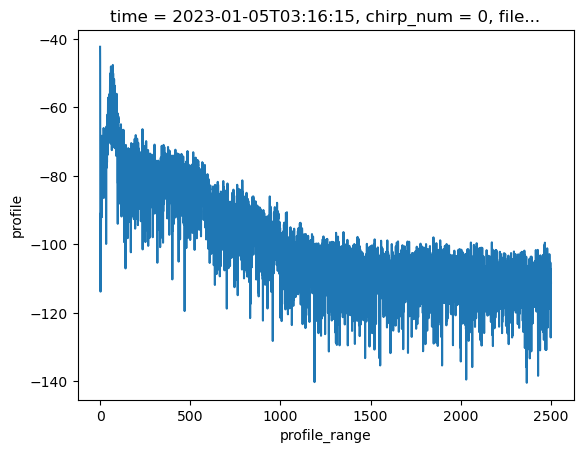

In [83]:
xa.data.profile.sel(chirp_num=0).db().plot()

In [87]:
xa.data.profile.db()

<xarray.DataArray 'profile' (orientation: 1, waypoint: 1, profile_range: 11889,
                             chirp_num: 100, attenuator_setting_pair: 1)>
array([[[[[ -42.28073632],
          [ -42.27714947],
          [ -42.27551755],
          ...,
          [ -42.4301079 ],
          [ -42.43066293],
          [ -42.43079762]],

         [[ -43.38280421],
          [ -43.37916976],
          [ -43.37741661],
          ...,
          [ -43.53219466],
          [ -43.532608  ],
          [ -43.53274026]],

         [[ -46.80191088],
          [ -46.79830027],
          [ -46.79605132],
          ...,
...
          ...,
          [-106.31623199],
          [-111.99411834],
          [-115.03436998]],

         [[-110.09857399],
          [-104.17003826],
          [-109.10601949],
          ...,
          [-106.09098556],
          [-111.12387041],
          [-114.50824026]],

         [[-111.19583459],
          [-105.96776455],
          [-109.45166043],
          ...,
          [-106.41077227],
          [-112.12790572],
          [-114.39244078]]]]])
Coordinates:
    time           (orientation, waypoint) datetime64[ns] 2023-01-05T03:16:15
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 2.5e+03 2.5e+03
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
    filename       (orientation, waypoint) <U57 '../../data/sample/single_dat...
    burst_number   (orientation, waypoint) int64 0
    AFGain         (attenuator_setting_pair) int64 -4
    attenuator     (attenuator_setting_pair) float64 22.0
  * orientation    (orientation) <U7 'unknown'
  * waypoint       (waypoint) int64 1
Dimensions without coordinates: attenuator_setting_pair

In [44]:
import glob

#search_suffix = str()

#dat_filenames = glob.glob(directory_names(0) + '/**/*' + search_suffix + '.DAT',recursive = True)

xa = ApRESDefs.xapres()
files = xa.list_files(directory="../../data", search_suffix='VV')
files

['../../data/sample/polarmetric/DATA2023-01-05-0313-VV.DAT']

In [45]:
xa.dat_filenames

['../../data/sample/polarmetric/DATA2023-01-05-0313-VV.DAT']

In [49]:
importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres()
xa
xa.load_all(attended=True, directory_list=["../../data/sample/polametric"])

NameError: name 'ApRESDefs' is not defined

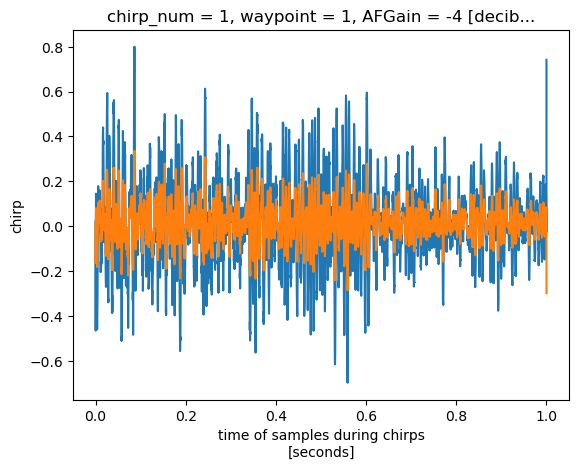

In [9]:

# to plot select one orientation you can use `.sel`
singleWaypoint.sel(orientation='HH', chirp_num = 1).chirp.plot()

# to average over all orientations:
singleWaypoint.sel(chirp_num = 1).chirp.mean(dim = 'orientation').plot()

## notes below this. 


The cells below are from trying to work out how best to expand the dimensions of the variables to get them to align with the dimensions we need for the unattended xarray

In [49]:

np.expand_dims([burst.Header['Latitude']], axis=(0, 1)).shape

(1, 1, 1)

In [60]:
lat_temp = np.expand_dims([burst.Header['Latitude']], axis=0)
type(lat_temp)

numpy.ndarray

In [89]:
time = np.expand_dims(np.array(time_temp), axis=0)

np.array(time_temp)

array(Timestamp('2023-01-05 03:16:15'), dtype=object)

In [120]:
filename = np.array(burst.Filename, ndmin = 2)
filename[0,0]

'../../data/sample/polarmetric/DATA2023-01-05-0315-VH.DAT'

In [125]:
t = np.array(time_temp, ndmin = 2)
t

array([[Timestamp('2023-01-05 03:16:15')]], dtype=object)

In [129]:
lat = np.array(burst.Header['Latitude'], ndmin = 2)
lat

array([[0.]])

In [127]:
np.expand_dims([burst.Header['Latitude']], axis=0)

array([[0.]])

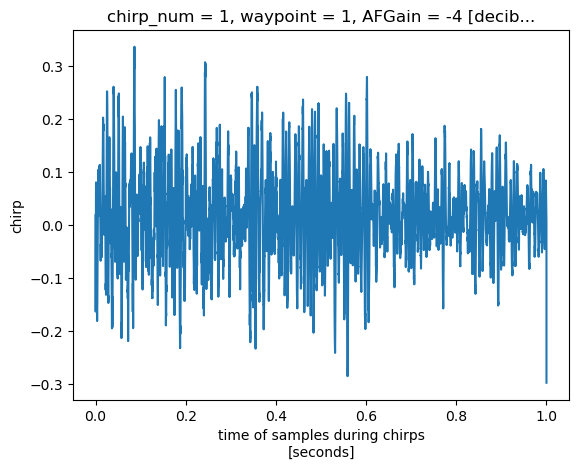

In [8]:
mean_of_waypoint = singleWaypoint.sel(chirp_num = 1).chirp.mean(dim = 'orientation').plot()


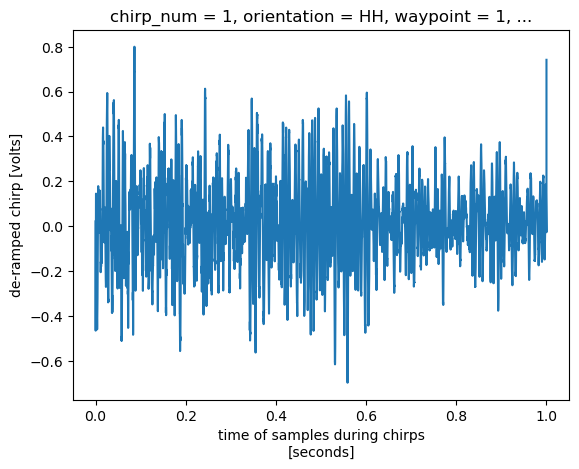

In [155]:
singleWaypoint.sel(orientation='HH', chirp_num = 1).chirp.plot()


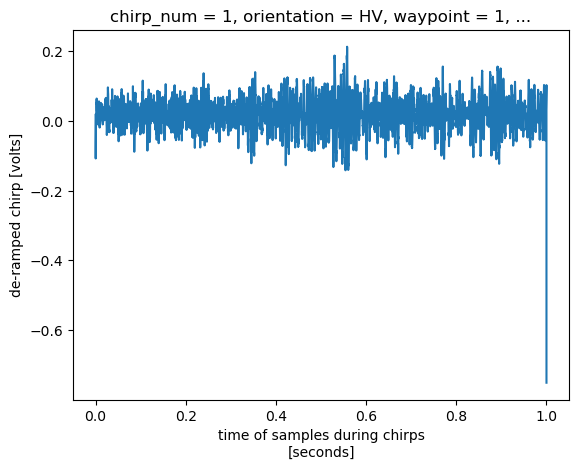

In [156]:
singleWaypoint.sel(orientation='HV', chirp_num = 1).chirp.plot()


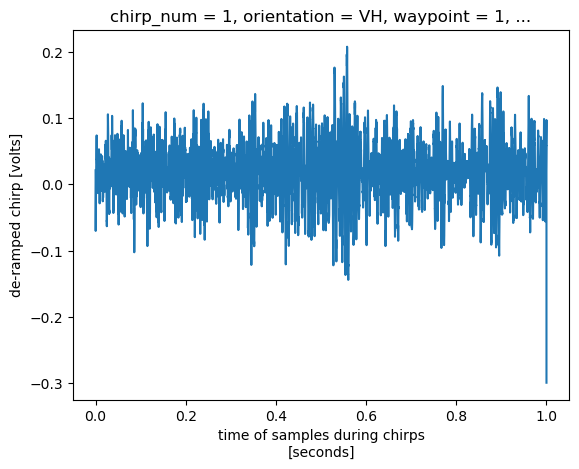

In [157]:
singleWaypoint.sel(orientation='VH', chirp_num = 1).chirp.plot()


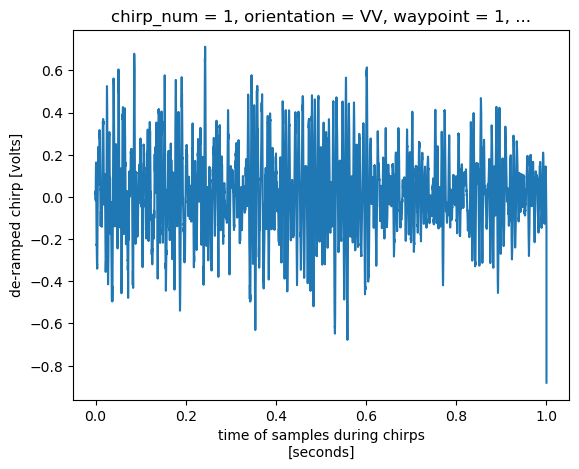

In [158]:
singleWaypoint.sel(orientation='VV', chirp_num = 1).chirp.plot()


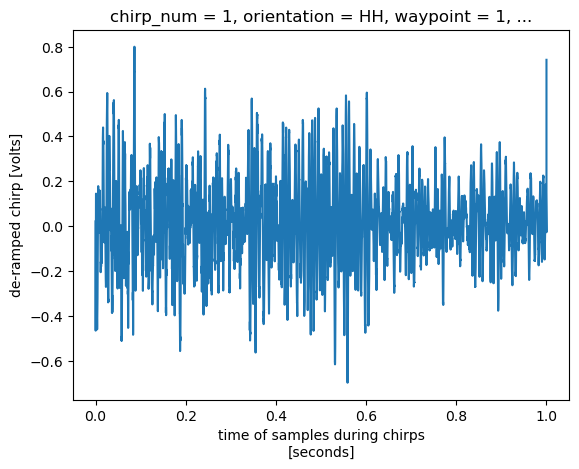

In [159]:
singleWaypoint.sel(orientation='HH', chirp_num = 1).chirp.plot()


In [45]:
filepaths


['../../data/sample/polarmetric/DATA2023-01-05-0315-VH.DAT',
 '../../data/sample/polarmetric/DATA2023-01-05-0310-HV.DAT',
 '../../data/sample/polarmetric/DATA2023-01-05-0307-HH.DAT',
 '../../data/sample/polarmetric/DATA2023-01-05-0313-VV.DAT']

In [47]:
xa.load_all(directory='../../data', file_numbers_to_process=[0])
xa

In [63]:
xa.data

<xarray.Dataset>
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-05T03:16:15
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U56 '../../data/sample/polarmetric/DATA2023-01-0...
    burst_number     (time) int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      (time) <U2 'VH'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0
    longitude        (time) float64 0.0
    battery_voltage  (time) float64 0.0
    temperature_1    (time) float64 2.891
    temperature_2    (time) float64 511.8

In [90]:
orientation_number = 2

xa.load_all(directory='../../data', file_numbers_to_process=[waypoint_number])

new_dims = {"waypoint": waypoint_number, 'orientations': orientation_number}
xa.data.drop

temp = xa.data.expand_dims(new_dims).squeeze(dim='time')


temp['time'] = temp.time.expand_dims(dim=new_dims)
temp['filename'] = temp.filename.expand_dims(dim=new_dims)
#temp['orientation'] = temp.orientation.expand_dims(dim=new_dims)
temp['burst_number'] = temp.burst_number.expand_dims(dim=new_dims)
temp

<xarray.Dataset>
Dimensions:          (waypoint: 1, orientations: 2, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (waypoint, orientations) datetime64[ns] 2023-01-05T03:10...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (waypoint, orientations) <U56 '../../data/sample/polarme...
    burst_number     (waypoint, orientations) int64 0 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      <U2 'HV'
Dimensions without coordinates: waypoint, orientations, attenuator_setting_pair
Data variables:
    chirp            (waypoint, orientations, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (waypoint, orientations, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (waypoint, orientations) float64 0.0 0.0
    longitude        (waypoint, orientations) float64 0.0 0.0
    battery_voltage  (waypoint, orientations) float64 0.0 0.0
    temperature_1    (waypoint, orientations) float64 503.1 503.1
    temperature_2    (waypoint, orientations) float64 503.6 503.6

In [98]:
import xarray as xr
import numpy as np
xa.load_all(directory='../../data', file_numbers_to_process=[waypoint_number])
temp = xa.data.squeeze(dim='time')
temp

<xarray.Dataset>
Dimensions:          (chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
    time             datetime64[ns] 2023-01-05T03:10:34
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         <U56 '../../data/sample/polarmetric/DATA2023-01-05-0310-...
    burst_number     int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      <U2 'HV'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         float64 0.0
    longitude        float64 0.0
    battery_voltage  float64 0.0
    temperature_1    float64 503.1
    temperature_2    float64 503.6

In [119]:
temp2 = xa.data.squeeze(dim='time').expand_dims(dim =  {"orientation": 1, "waypoint": 1})
temp3 = xa.data.squeeze(dim='time').expand_dims(dim =  {"orientation": 1, "waypoint": 1})

concated = xr.concat([temp2, temp3], dim = 'orientation')
concated

<xarray.Dataset>
Dimensions:          (orientation: 2, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             datetime64[ns] 2023-01-05T03:10:34
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         <U56 '../../data/sample/polarmetric/DATA2023-01-05-0310-...
    burst_number     int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
  * orientation      (orientation) <U2 'HV' 'HV'
Dimensions without coordinates: waypoint, attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (orientation, waypoint) float64 0.0 0.0
    longitude        (orientation, waypoint) float64 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 0.0 0.0
    temperature_1    (orientation, waypoint) float64 503.1 503.1
    temperature_2    (orientation, waypoint) float64 503.6 503.6

In [120]:

temp2 = xa.data.squeeze(dim='time').expand_dims(dim =  {"orientation": 1, "waypoint": 1})


temp2['time'] = temp2.time.expand_dims(dim =  {"orientation": 1, "waypoint": 1})
temp2['filename'] = temp2.filename.expand_dims(dim= {"orientation": 1, "waypoint": 1})
#temp2['orientation'] = temp2.orientation.expand_dims(dim={"waypoint": 1})
temp2['burst_number'] = temp2.burst_number.expand_dims(dim= {"orientation": 1, "waypoint": 1})
temp2

<xarray.Dataset>
Dimensions:          (chirp_time: 40001, profile_range: 11889, chirp_num: 100,
                      orientation: 1, waypoint: 1, attenuator_setting_pair: 1)
Coordinates:
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * orientation      (orientation) <U2 'HV'
    time             (orientation, waypoint) datetime64[ns] 2023-01-05T03:10:34
    filename         (orientation, waypoint) <U56 '../../data/sample/polarmet...
    burst_number     (orientation, waypoint) int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
Dimensions without coordinates: waypoint, attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (orientation, waypoint) float64 0.0
    longitude        (orientation, waypoint) float64 0.0
    battery_voltage  (orientation, waypoint) float64 0.0
    temperature_1    (orientation, waypoint) float64 503.1
    temperature_2    (orientation, waypoint) float64 503.6

In [133]:
waypoint_number=  2
temp2 = xa.data.assign_coords(waypoint = waypoint_number).squeeze(dim='time').expand_dims(dim =  {"orientation": 1, "waypoint": 1})
temp2

<xarray.Dataset>
Dimensions:          (orientation: 1, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             datetime64[ns] 2023-01-05T03:13:29
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         <U56 '../../data/sample/polarmetric/DATA2023-01-05-0313-...
    burst_number     int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
  * orientation      (orientation) <U2 'VV'
  * waypoint         (waypoint) int64 2
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (orientation, waypoint) float64 0.0
    longitude        (orientation, waypoint) float64 0.0
    battery_voltage  (orientation, waypoint) float64 0.0
    temperature_1    (orientation, waypoint) float64 2.492
    temperature_2    (orientation, waypoint) float64 4.93

In [137]:
waypoint_number = 1

list_of_singleOrientation_xarrays = []

for fileNumber in [0, 1, 2, 3]:
    xa = ApRESDefs.xapres()
    xa.load_all(directory='../../data', file_numbers_to_process=[fileNumber])

    temp2 = xa.data.assign_coords(waypoint = waypoint_number).squeeze(dim='time').expand_dims(dim =  {"orientation": 1, "waypoint": 1})


    temp2['time'] = temp2.time.expand_dims(dim =  {"orientation": 1, "waypoint": 1})
    temp2['filename'] = temp2.filename.expand_dims(dim= {"orientation": 1, "waypoint": 1})
    temp2['burst_number'] = temp2.burst_number.expand_dims(dim= {"orientation": 1, "waypoint": 1})
    temp2

    list_of_singleOrientation_xarrays.append(temp2)
    
singleWaypoint = xr.concat(list_of_singleOrientation_xarrays, dim = 'orientation')
singleWaypoint.sel(orientation='HH', chirp_num = 1).chirp.plot()

In [138]:
singleWaypoint


<xarray.Dataset>
Dimensions:          (chirp_time: 40001, profile_range: 11889, chirp_num: 100,
                      orientation: 4, waypoint: 1, attenuator_setting_pair: 1)
Coordinates:
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * orientation      (orientation) <U2 'VH' 'HV' 'HH' 'VV'
  * waypoint         (waypoint) int64 1
    time             (orientation, waypoint) datetime64[ns] 2023-01-05T03:16:...
    filename         (orientation, waypoint) <U56 '../../data/sample/polarmet...
    burst_number     (orientation, waypoint) int64 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    longitude        (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 0.0 0.0 0.0 0.0
    temperature_1    (orientation, waypoint) float64 2.891 503.1 502.9 2.492
    temperature_2    (orientation, waypoint) float64 511.8 503.6 501.6 4.93

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type complex128 instead.

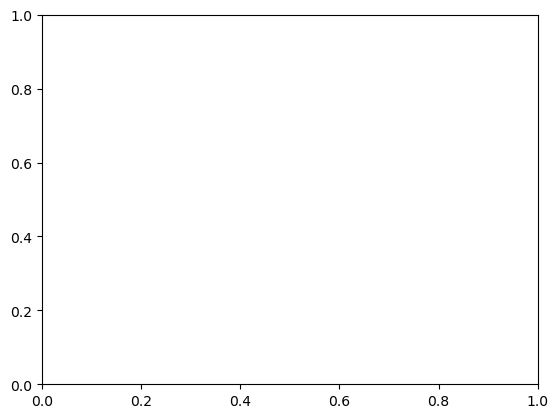

In [141]:
singleWaypoint.sel(orientation='HH', chirp_num = 1).chirp.plot()

In [37]:
xa2 = ApRESDefs.xapres()
xa2.load_all(directory='gs://ldeo-glaciology/GL_apres_2022', 
            remote_load = True,
            file_numbers_to_process = [0, 1], 
            bursts_to_process=[0, 1]
           )
xa2.data.orientation

<xarray.DataArray 'orientation' (time: 3)>
array(['unknown', 'unknown', 'unknown'], dtype='<U7')
Coordinates:
  * time          (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-05-26T15...
    filename      (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR20...
    burst_number  (time) int64 0 1 0
    orientation   (time) <U7 'unknown' 'unknown' 'unknown'
Attributes:
    description:  HH, HV, VH, or VV antenna orientation as described in Ersah...

In [29]:
filepaths[0]

'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT'

In [30]:
xa2.load_all(directory='gs://ldeo-glaciology/GL_apres_2022', 
            remote_load = True,
            file_numbers_to_process = [0, 1], 
            bursts_to_process=[0, 1]
           )

DEBUG    12:05:03 	 ApRESDefs.py @function list_files line 166 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022 with remote_load = True
DEBUG    12:05:04 	 ApRESDefs.py @function list_files line 180 - Finish call to list_files. Found 386 files
DEBUG    12:05:04 	 ApRESDefs.py @function load_all line 212 - Subset files to [0, 1]
DEBUG    12:05:04 	 ApRESDefs.py @function load_all line 228 - Starting loop over dat files
DEBUG    12:05:04 	 ApRESDefs.py @function load_all line 231 - Load dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
DEBUG    12:05:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 255 - This dat file has 13 bursts.
DEBUG    12:05:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 256 - bursts_to_process = [0, 1] at the start of _all_bursts_in_dat_to_xarray.
DEBUG    12:05:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 269 - bursts_to_process = [0, 1] after initi

In [34]:
xa2.data

<xarray.Dataset>
Dimensions:          (time: 3, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 4280)
Coordinates:
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-05-26...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 0.4206 ... 899.6 899.8
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
    burst_number     (time) int64 0 1 0
    AFGain           (time, attenuator_setting_pair) int64 -14 -14 ... -4 -14
    attenuator       (time, attenuator_setting_pair) float64 10.0 20.0 ... 5.0
    orientation      (time) <U7 'unknown' 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 69.22 69.22 68.71
    longitude        (time) float64 -51.12 -51.12 -49.55
    battery_voltage  (time) float64 12.33 12.48 13.93
    temperature_1    (time) float64 4.383 7.32 2.812
    temperature_2    (time) float64 5.195 1.469 2.25